In [1]:
import numpy as np
import pyatsol
from multiprocessing import Pool
from itertools import starmap, chain
from scipy.optimize import minimize
from collections import OrderedDict
import pickle
import pandas as pd
from caflib.Tools import geomlib

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-whitegrid')
mpl.rc('font', family='serif', serif='Myriad Pro')
mpl.rc('mathtext', fontset='stixsans')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def solve_atom(*args):
    return pyatsol.lib.solve_atom(*args)

def savefig(fig, name):
    fig.savefig(
        f'{name}.pdf',
        transparent=True,
        bbox_inches='tight',
    )

pyatsol.data['Cr']['shell_occ'] = [2, 2, 6, 2, 6, 4, 2]
pyatsol.data['Cu']['shell_occ'] = [2, 2, 6, 2, 6, 9, 2]
pyatsol.data['Nb']['shell_occ'] = [2, 2, 6, 2, 6, 10, 2, 6, 3, 2]
pyatsol.data['Mo']['shell_occ'] = [2, 2, 6, 2, 6, 10, 2, 6, 4, 2]
pyatsol.data['Ru']['shell_occ'] = [2, 2, 6, 2, 6, 10, 2, 6, 6, 2]
pyatsol.data['Rh']['shell_occ'] = [2, 2, 6, 2, 6, 10, 2, 6, 7, 2]
pyatsol.data['Pd']['shell_n'] = [1, 2, 2, 3, 3, 3, 4, 4, 4, 5]
pyatsol.data['Pd']['shell_l'] = [0, 0, 1, 0, 1, 2, 0, 1, 2, 0]
pyatsol.data['Pd']['shell_occ'] = [2, 2, 6, 2, 6, 10, 2, 6, 8, 2]
pyatsol.data['Ag']['shell_occ'] = [2, 2, 6, 2, 6, 10, 2, 6, 9, 2]

nrad = 700
# nrad = 3000
r, rw = pyatsol.lib.init_grid(nrad, 1e-3, 1.017)
# r, rw = atsol.init_grid(nrad, 1e-3, 1.004)
r[-1]

131.0215637122463

In [2]:
pyatsol.lib.verbosity = 2
np.seterr(all='ignore');

### Atomic radii

In [3]:
pyatsol.data['H']

{'C6(BG)': 6.51,
 'C6(TS)': 6.5,
 'N': 1,
 'O1': 0.4037,
 'O2': 1.0098,
 'Rvdw': 3.1,
 'Z': 1,
 'a1': 0.6825,
 'a2': 0.3175,
 'alpha0(BG)': 4.499159818,
 'alpha0(TS)': 4.5,
 'alpha02': 15,
 'in': 1,
 'ionization energy': 13.5984,
 'mass': 1.0079,
 'name': 'hydrogen',
 'p': 1.847,
 'pp': 1.232,
 'shell_l': [0],
 'shell_n': [1],
 'shell_occ': [1],
 'symbol': 'H'}

### Functions

In [4]:
def nopol(densities):
    """sum over spin"""
    def reduce(v):
        return v.sum(1) if v.shape == (nrad, 2) else v
    if isinstance(densities, dict):
        return {k: reduce(v) for k, v in densities.items()}
    else:
        return [reduce(v) for v in densities]

In [5]:
def plot_dens(ax, *curves, xlim=None, ylim=None, legend=None):
    nr = np.nonzero(r > xlim)[0][0]-1 if xlim else len(r)
    for curve in curves:
        if isinstance(curve, tuple):
            curve, kw = curve
        else:
            kw = {}
        ax.plot(r[150:nr], curve[150:nr], **kw)
    # ax.legend(legend or [str(i+1) for i in range(len(curves))])
    ax.legend()
    if ylim:
        ax.set_ylim(*ylim)

In [6]:
def quad(y, lim=(0, np.inf)):
    global r, rw
    a = np.nonzero(r >= lim[0])[0][0]
    b = np.nonzero(r < lim[1])[0][-1]+1
    return np.sum(y[a:b]*4*np.pi*r[a:b]**2*rw[a:b])

In [7]:
def get_C6(densities, func):
    return 3/np.pi*np.sum(
        uw*quad(func(u=u, **densities))**2
        for u, uw in zip(mbd.omega_grid, mbd.omega_grid_w))

In [8]:
def getn(n, **kw):
    return n

def gethirsh(n, **kw):
    return n*r**3

def VV10(n, grad, u=0, **kw):
    if any(n < 0):
        return np.nan*n
    return n/(4/3*np.pi*n+.755**2/64*(grad/n)**4+u**2)

def kinalpha(n, grad, kin, **kw):
    alpha = (kin-grad**2/(8*n))/(3/10*(3*np.pi**2)**(2/3)*n**(5/3))
    alpha = np.where(alpha < 0, 0, alpha)
    return alpha

In [9]:
def get_scaling(densities, confinements, symbol, func):
    lim = (0, 50)
    data = []
    vol0 = quad(gethirsh(**densities[symbol]), lim=lim)
    alpha0 = quad(func(u=1e-6, **densities[symbol]), lim=lim)
    C60 = get_C6(densities[symbol], func)
    for conf in confinements[:-1]:
        scale_vol = quad(gethirsh(**densities[symbol, conf]), lim=lim)/vol0
        scale_alpha = quad(func(u=1e-6, **densities[symbol, conf]), lim=lim)/alpha0
        scale_C6 = get_C6(densities[symbol, conf], func)/C60
        data.append((scale_vol, scale_alpha, scale_C6))
    data = np.log(np.array(data))
    p1 = np.polyfit(data[:, 0], data[:, 1], 1)
    p2 = np.polyfit(data[:, 0], data[:, 2], 1)
    return p1[0], p2[0]

In [10]:
def sigl(x):
    return 1/(1+np.exp(-x))

def siga(x):
    return (1+x/np.sqrt(1+x**2))/2

### Get densities

In [11]:
# this takes ca 180 seconds on a modern 2-core laptop
confinements = [6, 8, 10, 15, 30, np.inf]
densities = OrderedDict()
for round in range(2):
    keys = []
    args = []
    for data in pyatsol.data.values():
        if not data['in']:
            continue
        if (data['N'] == data['Z']) != (round == 0):
            continue
        # if data['N'] > 6:
        #     continue
        for confinement in confinements:
            if data['N'] > data['Z'] and not (
                    data['N'] == data['Z']+1 and data['N'] in [10, 18, 36, 54]):
                Rw = pyatsol.data[pyatsol.symbol[data['Z'], data['Z']]]['hirsh']**(1/3)
                q = data['N']-data['Z']
                conf_pot = np.where(r < Rw, -2*q/Rw, -2*q/r)
            else:
                conf_pot = np.zeros((nrad,))
            keys.append((data['symbol'], confinement))
            conf_pot += r**2/confinement**3
            args.append((
                data['Z'], 
                data['shell_n'], data['shell_l'], data['shell_occ'],
                conf_pot, 'PBE'))
    with Pool(2) as p:
        densities_out = p.starmap(solve_atom, args)
    # densities_out = starmap(solve_atom, args)
    for (symbol, conf), dens in zip(keys, densities_out):
        densities[symbol if conf == np.inf else (symbol, conf)] = \
            nopol(dict(zip('n grad lap kin nsh kinsh zo'.split(), dens)))
        if conf == np.inf:
            pyatsol.data[symbol]['hirsh'] = quad(gethirsh(**densities[symbol]))

### Test external potentials/scaling

[36.57200795058122, 30.20169423944554, 30.44671820259635]
[11.491505699781717, 9.483495456709342, 8.833010166135114]
1.0035010352289169 1.4353802419287967


/Users/hermann/.local/share/virtualenvs/mbd-vv-simple-dpl5qCzq/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hermann/.local/share/virtualenvs/mbd-vv-simple-dpl5qCzq/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1201: UserWarning: 'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


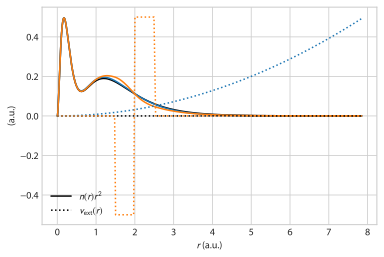

In [12]:
def step_pot(a, b, val):
    return np.where(
        np.logical_and(a < r, r < b),
        val*np.ones_like(r), np.zeros_like(r)
    )
    
def figure_pot(fig, ax):
    data = pyatsol.data['C']
    pots = [
        0*r,
        r**2/5**3,
        step_pot(1.5, 2, -0.5)+step_pot(2, 2.5, 0.5)
    ]
    densities = [
        nopol(solve_atom(
            data['Z'], 
            data['shell_n'], data['shell_l'], data['shell_occ'],
            pot, 'PBE'
        ))[:2] for pot in pots
    ]
    V = [quad(n*r**3) for n, grad in densities]
    a = [quad(VV10(n, grad)) for n, grad in densities]
    print(V)
    print(a)
    print(np.log(a[1]/a[0])/np.log(V[1]/V[0]), np.log(a[2]/a[0])/np.log(V[2]/V[0]))
    colors = ['black', None, None]
    nr = np.nonzero(r > 8)[0][0]-1
    lines = {}
    for (n, grad), c in zip(densities, colors):
        line, = ax.plot(r[:nr], (n*r**2)[:nr], color=c)
        lines.setdefault(r'$n(r)r^2$', line)
    ax.set_color_cycle(None)
    for pot, c in zip(pots, colors):
        line, = ax.plot(r[:nr], pot[:nr], color=c, ls='dotted')
        lines.setdefault(r'$v_\mathrm{ext}(r)$', line)
    ax.set_xlabel(r'$r$ (a.u.)')
    ax.set_ylabel(r'(a.u.)')
    ax.legend(lines.values(), lines.keys())
    
fig, ax = plt.subplots()
figure_pot(fig, ax)
savefig(fig, '/Users/hermann/Research/Projects/dissertation/pub/media/scaling-c')

### Plot several atoms

In [13]:
def my(n, grad, kin, nsh, kinsh, zo, u=0, **kw):
    if any(n < 0):
        return np.nan*n
    ion = np.abs(kin/n)
    ionw = grad**2/(8*n**2)
    pol = np.zeros_like(n)
    for ni, kini, zoi in zip(
            nsh.T.reshape((-1, nrad)),
            kinsh.T.reshape((-1, nrad)),
            zo.reshape((-1,))):
        ioni = kini/ni
        w2i = 1.7*n+np.abs(0.75*ioni)**2
        w2i[0] = np.inf
        pol += zoi*ni/(w2i+u**2)
    return pol

In [14]:
def my2(n, grad, kin, nsh, kinsh, zo, inp=lambda a: siga(1*(a-.9)), u=0, **kw):
    if any(n < 0):
        return np.nan*n
    kin = np.where(np.isnan(kin), 0, kin)
    ion = np.abs(kin/n)
    ionw = grad**2/(8*n**2)
    alpha = kinalpha(n, grad, kin)
    c = inp(alpha)
    # pol = n/(1.7*n+(0.75*(c*ionw+(1-c)*ion))**2)
    pol = n/(1.7*n+c*(0.75*ionw)**2+(1-c)*(0.75*ion)**2+u**2)
    return pol

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'MyriadPro-SemiExt.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))
/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


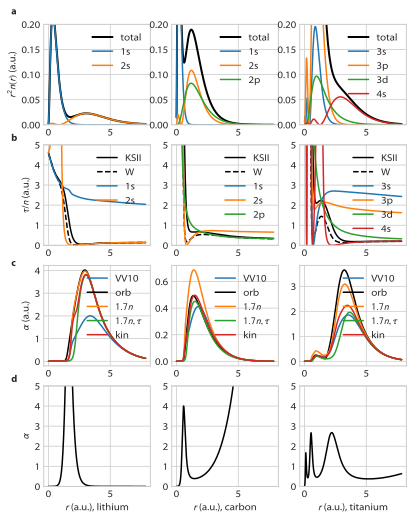

In [15]:
def plot_info(ax, dens, shells):
    plot_dens(ax[0],
        (dens['n']*r**2, {'color': 'black', 'lw': 2, 'label': 'total'}),
        *((occ*dens['nsh'][:, 0, ish]*r**2, {'label': lbl}) for occ, ish, lbl in shells),
        xlim=8, ylim=(0, .2))
    plot_dens(ax[1],
        ((lambda n, kin, **kw: kin/n)(**dens), {'color': 'black', 'label': 'KSII'}),
        ((lambda n, grad, **kw: grad**2/(8*n**2))(**dens), {'color': 'black', 'ls': 'dashed', 'label': 'W'}),
        *(((lambda nsh, kinsh, **kw: kinsh[:, 0, ish]/nsh[:, 0, ish])(**dens), {'label': lbl}) for _, ish, lbl in shells),
        xlim=8, ylim=(0, 5))
    plot_dens(ax[2],
        (r**2*(lambda n, grad, **kw: n/(4.2*n+(0.75*grad**2/(8*n**2))**2))(**dens), {'label': 'VV10'}),
        (r**2*my(**dens), {'label': 'orb', 'color': 'black'}),
        (r**2*(lambda n, grad, **kw: n/(1.7*n+(0.75*grad**2/(8*n**2))**2))(**dens), {'label': '$1.7n$'}),
        (r**2*(lambda n, kin, **kw: n/(1.7*n+(0.75*kin/n)**2))(**dens), {'label': r'$1.7n,\tau$'}),
        (r**2*my2(**dens), {'label': 'kin'}),
        xlim=8)
    plot_dens(ax[3],
        (kinalpha(**dens), {'color': 'black'}),
        xlim=8, ylim=(0, 5))

fig, axes = plt.subplots(4, 3, figsize=(6.5, 8.5))
plot_info(axes[:, 0], densities['Li'], [(2, 0, '1s'), (1, 1, '2s')])
plot_info(axes[:, 1], densities['C'], [(2, 0, '1s'), (2, 1, '2s'), (2, 2, '2p')])
plot_info(axes[:, 2], densities['Ti'], [(2, 3, '3s'), (6, 4, '3p'), (2, 5, '3d'), (2, 6, '4s')])
for ax, lbl in zip(axes[-1, :], 'lithium carbon titanium'.split()):
    ax.set_xlabel(rf'$r$ (a.u.), {lbl}')
for ax, lbl in zip(axes[:, 0], [r'$r^2n(r)$ (a.u.)', r'$\tau/n$ (a.u.)', r'$\alpha$ (a.u.)', r'$\alpha$']):
    ax.set_ylabel(lbl)
for i, (lbl, y) in enumerate(zip('abcd', [.22, 5.2, 4.2, 5.2])):
    axes[i, 0].text(-3, y, lbl, weight='bold')
savefig(fig, '/Users/hermann/Research/Projects/dissertation/pub/media/atomic-densities')

(0, 12)

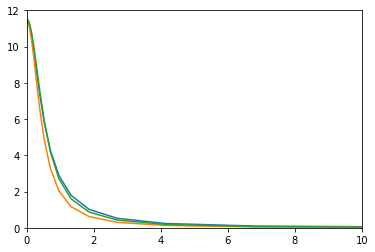

In [16]:
plt.plot(
    mbd.omega_grid,
    [quad(VV10(u=u, **densities['C'])) for u in mbd.omega_grid],
    mbd.omega_grid,
    2.26/(.446**2+mbd.omega_grid**2),
    mbd.omega_grid,
    3.23/(.53**2+mbd.omega_grid**2)
)
plt.xlim((0, 10))
plt.ylim((0, 12))

In [18]:
quad(gethirsh(**densities['C', 6]))

32.136047126657481

In [19]:
get_scaling(densities, confinements, 'C', VV10)

(0.99500837851775514, 1.2602057636936874)

In [20]:
def logistic(x, x0, k):
    return 1/(1+np.exp(-k*(x-x0)))

In [21]:
4*np.pi/3, (.75/8)**2

(4.1887902047863905, 0.0087890625)

In [22]:
def f(n, grad, kin, **kw):
    alpha = (kin-grad**2/(8*n))/(3/10*(3*np.pi**2)**(2/3)*n**(5/3))
    return alpha

plt.figure(figsize=(10, 7))
plot_dens(
    # f(**densities['He']),
    # f(**densities['Ne']),
    # f(**densities['Ar']),
    # f(**densities['Kr']),
    # f(**densities['Xe']),
    f(**densities['H']),
    f(**densities['He']),
    f(**densities['Li']),
    f(**densities['Be']),
    f(**densities['Na']),
    f(**densities['Ca']),
    xlim=7, ylim=(0, 13))

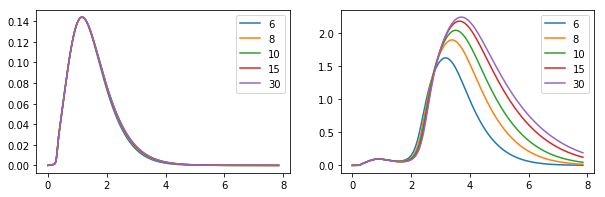

In [23]:
    plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_dens(
    *[VV10(**densities['Ne', conf])*r**2
      for conf in confinements if conf != np.inf],
    xlim=8, legend=confinements)
plt.subplot(1, 2, 2)
plot_dens(
    *[VV10(**densities['Na', conf])*r**2
      for conf in confinements if conf != np.inf],
    xlim=8, legend=confinements)

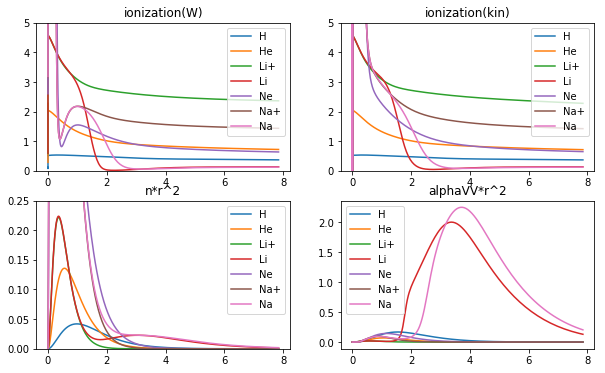

In [24]:
elems = 'H He Li+ Li Ne Na+ Na'.split()
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plot_dens(
    *[(lambda n, grad, **kw: grad**2/(8*n**2))(**densities[el])
      for el in elems],
    xlim=8, ylim=(0, 5), legend=elems)
plt.title('ionization(W)')
plt.subplot(2, 2, 2)
plot_dens(
    *[(lambda n, kin, **kw: kin/n)(**densities[el])
      for el in elems],
    xlim=8, ylim=(0, 5), legend=elems)
plt.title('ionization(kin)')
plt.subplot(2, 2, 3)
plot_dens(
    *[getn(**densities[el])*r**2
      for el in elems],
    xlim=8, ylim=(0, .25), legend=elems)
plt.title('n*r^2')
plt.subplot(2, 2, 4)
plot_dens(
    *[VV10(**densities[el])*r**2
      for el in elems],
    xlim=8, legend=elems)
plt.title('alphaVV*r^2')

### Dataset

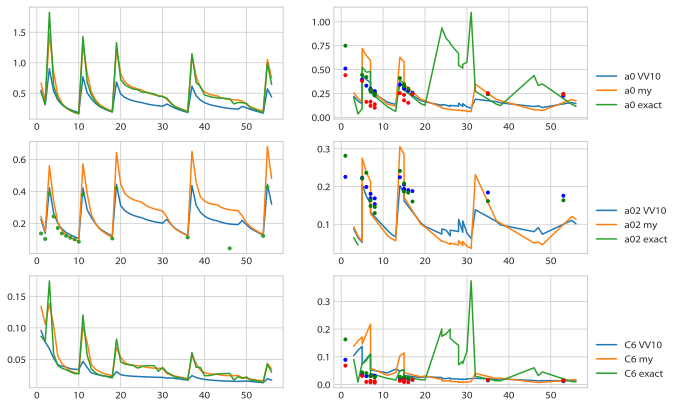

In [25]:
table = []
lines = []
lines_cation = []
lines_anion = []
for symbol, data in pyatsol.data.items():
    if not data['in']:
        continue
    alpha0 = quad(VV10(u=1e-6, **densities[symbol]))
    alpha0_my = quad(my(u=1e-6, **densities[symbol]))
    alpha02 = quad(VV10(u=1e-6, **densities[symbol])*r**2)
    alpha02_my = quad(my(u=1e-6, **densities[symbol])*r**2)
    C6 = get_C6(densities[symbol], VV10)
    C6_my = get_C6(densities[symbol], my)
    hirsh = data['hirsh']
    hirsh5 = quad(densities[symbol]['n']*r**5)
    alpha0_ref, C6_ref, alpha02_ref = data['alpha0(BG)'], data['C6(BG)'], data.get('alpha02', np.nan)
    row = [
        alpha0, alpha0_my, alpha0_ref,
        alpha02, alpha02_my, data.get('alpha02'),
        C6, C6_my, C6_ref,
        symbol]
    table.append(row)
    if symbol in ['F-']:
        continue
    (lines if data['N'] == data['Z'] else lines_cation if data['N'] < data['Z'] else lines_anion).append((
            data['Z'],
            alpha0/hirsh, alpha0_my/hirsh, alpha0_ref/hirsh,
            alpha02/hirsh5, alpha02_my/hirsh5, alpha02_ref/hirsh5,
            C6/hirsh**2, C6_my/hirsh**2, C6_ref/hirsh**2))
ls = np.array(lines).T
plt.figure(figsize=(10, 7))
plt.subplot(3, 2, 1)
plt.plot(ls[0], ls[1], ls[0], ls[2], ls[0], ls[3])
plt.subplot(3, 2, 3)
plt.plot(ls[0], ls[4], ls[0], ls[5], ls[0], ls[6], '.')
plt.subplot(3, 2, 5)
plt.plot(ls[0], ls[7], ls[0], ls[8], ls[0], ls[9])
ls = np.array(lines_cation).T
lsa = np.array(lines_anion).T
plt.subplot(3, 2, 2)
plt.plot(
    ls[0], ls[1], '-', ls[0], ls[2], '-', ls[0], ls[3], '-',
    lsa[0], lsa[1], 'b.', lsa[0], lsa[2], 'g.', lsa[0], lsa[3], 'r.')
plt.legend(['a0 VV10', 'a0 my', "a0 exact"], loc='lower left', bbox_to_anchor=((1, 0)))
plt.subplot(3, 2, 4)
plt.plot(
    ls[0], ls[4], '-', ls[0], ls[5], '-', ls[0], ls[6], '-',
    lsa[0], lsa[4], 'b.', lsa[0], lsa[5], 'g.', lsa[0], lsa[6], 'r.')
plt.legend(["a02 VV10", "a02 my", "a02 exact"], loc='lower left', bbox_to_anchor=((1, 0)))
plt.subplot(3, 2, 6)
plt.plot(
    ls[0], ls[7], '-', ls[0], ls[8], '-', ls[0], ls[9], '-',
    lsa[0], lsa[7], 'b.', lsa[0], lsa[8], 'g.', lsa[0], lsa[9], 'r.')
plt.legend(["C6 VV10", "C6 my", "C6 exact"], loc='lower left', bbox_to_anchor=((1, 0)))

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'MyriadPro-SemiExt.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


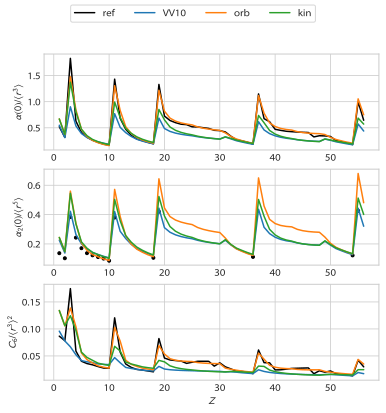

In [26]:
lines = []
for symbol, data in pyatsol.data.items():
    if not data['in'] or data['N'] != data['Z']:
        continue
    alpha0 = quad(VV10(u=1e-6, **densities[symbol]))
    alpha0_my = quad(my(u=1e-6, **densities[symbol]))
    alpha0_my2 = quad(my2(u=1e-6, **densities[symbol]))
    alpha02 = quad(VV10(u=1e-6, **densities[symbol])*r**2)
    alpha02_my = quad(my(u=1e-6, **densities[symbol])*r**2)
    alpha02_my2 = quad(my2(u=1e-6, **densities[symbol])*r**2)
    C6 = get_C6(densities[symbol], VV10)
    C6_my = get_C6(densities[symbol], my)
    C6_my2 = get_C6(densities[symbol], my2)
    hirsh = data['hirsh']
    hirsh5 = quad(densities[symbol]['n']*r**5)
    alpha0_ref, C6_ref, alpha02_ref = data['alpha0(BG)'], data['C6(BG)'], data.get('alpha02', np.nan)
    if data['N'] == 46:
        alpha02_ref = np.nan
    if symbol in ['F-']:
        continue
    lines.append((
        data['Z'],
        alpha0/hirsh, alpha0_my/hirsh, alpha0_my2/hirsh, alpha0_ref/hirsh,
        alpha02/hirsh5, alpha02_my/hirsh5, alpha02_my2/hirsh5, alpha02_ref/hirsh5,
        C6/hirsh**2, C6_my/hirsh**2, C6_my2/hirsh**2, C6_ref/hirsh**2))
lines = np.array(lines)

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
handles = {}
for i, lbl in zip([4, 1, 2, 3], ['ref', 'VV10', 'orb', 'kin']):
    for ax, ishift in zip(axes, [0, 4, 8]):
        extra = {}
        if i == 4 and ishift == 4:
            extra.update({'marker': '.', 'ls': 'none'})
        if i == 4:
            extra['color'] = 'black'
        handles[lbl], = ax.plot(lines[:, 0], lines[:, i+ishift], **extra)
axes[-1].set_xlabel(r'$Z$')
labels = [
    r'$\alpha(0)/\langle r^3\rangle$',
    r'$\alpha_2(0)/\langle r^5\rangle$',
    r'$C_6/\langle r^3\rangle^2$'
]
for ax, lbl in zip(axes, labels):
    ax.set_ylabel(lbl)
fig.legend(handles.values(), handles.keys(), 'upper center', ncol=4, frameon=True)
savefig(fig, '/Users/hermann/Research/Projects/dissertation/pub/media/pol-periodic-table')

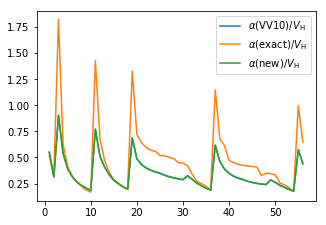

In [27]:
table = []
lines = []
lines_cation = []
lines_anion = []
for symbol, data in pyatsol.data.items():
    if not data['in']:
        continue
    alpha0 = quad(VV10(u=1e-6, **densities[symbol]))
    alpha0_my = quad(my(u=1e-6, **densities[symbol]))
    alpha02 = quad(VV10(u=1e-6, **densities[symbol])*r**2)
    alpha02_my = quad(my(u=1e-6, **densities[symbol])*r**2)
    C6 = get_C6(densities[symbol], VV10)
    C6_my = get_C6(densities[symbol], my)
    hirsh = data['hirsh']
    hirsh5 = quad(densities[symbol]['n']*r**5)
    alpha0_ref, C6_ref, alpha02_ref = data['alpha0(BG)'], data['C6(BG)'], data.get('alpha02', np.nan)
    row = [
        alpha0, alpha0_my, alpha0_ref,
        alpha02, alpha02_my, data.get('alpha02'),
        C6, C6_my, C6_ref,
        symbol]
    table.append(row)
    if symbol in ['F-']:
        continue
    (lines if data['N'] == data['Z'] else lines_cation if data['N'] < data['Z'] else lines_anion).append((
            data['Z'],
            alpha0/hirsh, alpha0_my/hirsh, alpha0_ref/hirsh,
            alpha02/hirsh5, alpha02_my/hirsh5, alpha02_ref/hirsh5,
            C6/hirsh**2, C6_my/hirsh**2, C6_ref/hirsh**2))
ls = np.array(lines).T
plt.figure(figsize=(5, 3.5))
plt.plot(ls[0], ls[1], ls[0], ls[3], ls[0], ls[2])
plt.legend([r'$\alpha(\mathrm{VV10})/V_\mathrm{H}$',
            r'$\alpha(\mathrm{exact})/V_\mathrm{H}$',
            r'$\alpha(\mathrm{new})/V_\mathrm{H}$'],
           loc='upper right')
plt.savefig('/Users/hermann/Downloads/fig.pdf')
# plt.show()
# plt.clf()

In [28]:
def my(n, grad, kin, nsh, kinsh, zo, u=0, **kw):
    if any(n < 0):
        return np.nan*n
    # a0 = 4
    # k = 1.3
    # a = kinalpha(n=n, grad=grad, kin=kin, **kw)
    # a = np.where(np.isnan(a), 0, a)
    # f = 1/(1+np.exp(-k*(a-a0)))
    # w2 = (4.2*n+0.75*(grad/n)**4)*(1-f+1e-20)+(.9*n+.012*(grad/n)**4)
    # ion = grad**2/(8*n**2)
    kin = np.where(np.isnan(kin), 0, kin)
    ion = kin/n
    ionw = grad**2/(8*n**2)
    alpha = kinalpha(n, grad, kin)
    c = siga(2*(alpha-.5))
    c = 1
    # pol = n/(1.7*n+(0.75*(c*ionw+(1-c)*ion))**2)
    pol = n/(4.2*n+c*(0.75*ionw)**2+(1-c)*(0.75*ion)**2+u**2)
    # for ni, kini, zoi in zip(
    #         nsh.T.reshape((-1, nrad)),
    #         kinsh.T.reshape((-1, nrad)),
    #         zo.reshape((-1,))):
    #     ioni = kini/ni
    #     # coeff = 1.3/(1+np.exp(-10*(ion-.27)))
    #     # coeff = 2.7*ion
    #     # coeff = .4
    #     # w2a = 2*n+np.abs(.75*ion)**2
    #     # w2i = (.75*ioni)**2*(1+8*n/ion**1.7)
    #     w2i = 1.7*n+np.abs(0.75*ionw)**2
    #     # w2i = 15*3/10*(3*np.pi**2)**(2/3)*n+(0.75*np.abs(ioni))**2
    #     # w2b = (1*ioni)**2
    #     # a = .2+.8/(1+np.exp(-20.*(ion-.35)))
    #     # a = 1
    #     # w2i = a*w2a+(1-a)*w2b
    #     w2i[0] = np.inf
    #     # w21 = 4.2*n+(.75*ion)**2
    #     # w22 = 0.4*n+(1.5*ion)**2
    #     # w2 = 4.2*n+(.65*kin/n)**2
    #     pol += zoi*ni/(w2i+u**2)
    #     # alpha[0] = 0
    #     # alpha = n*(1/(w2+u**2))
    return pol
 # 0.76107047  1.18004537  1.63910389  1.60009009
#  0.80589502  1.15682973  1.66033505  1.3700604 
#  0.8184682   1.12956866  1.72185627  1.37228423]

In [29]:
def target(args):
    C, A, B, gamma = args
    def my(n, grad, kin, nsh, kinsh, zo, u=0, **kw):
        if any(n < 0):
            return np.nan*n
        pol = np.zeros_like(n)
        for ni, kini, zoi in zip(
                nsh.T.reshape((-1, nrad)),
                kinsh.T.reshape((-1, nrad)),
                zo.reshape((-1,))):
            ioni = kini/ni
            w2i = np.abs(C*ioni)**2+(A+B/(1+gamma/ioni))*n
            w2i[0] = np.inf
            pol += zoi*ni/(w2i+u**2)
        return pol
    
    error = 0
    for symbol, data in pyatsol.data.items():
        if not data['in'] or data['N'] != data['Z']:
            continue
        alpha0_ref, C6_ref, alpha02_ref = data['alpha0(BG)'], data['C6(BG)'], data.get('alpha02', np.nan)
        alpha0_my = quad(my(u=1e-6, **densities[symbol]))
        if not np.isnan(alpha02_ref):
            alpha02_my = quad(my(u=1e-6, **densities[symbol])*r**2)
        C6_my = get_C6(densities[symbol], my)
        hirsh = data['hirsh']
        hirsh5 = quad(densities[symbol]['n']*r**5)
        error += np.abs(alpha0_my-alpha0_ref)/alpha0_ref*alpha0_ref/hirsh
        error += np.abs(C6_my-C6_ref)/C6_ref*C6_ref/hirsh**2*30
        if not np.isnan(alpha02_ref):
            error += np.abs(alpha02_my-alpha02_ref)/alpha02_ref*alpha02_ref/hirsh5*5
    print(args, error)
    return error

In [30]:
x0 = minimize(target, [.82, .4, 1.6, 0.01], method='Nelder-Mead', options={'disp': True, 'maxfev': 200})

[ 0.82  0.4   1.6   0.01] 17.6287825057
[ 0.861  0.4    1.6    0.01 ] 18.6196134005
[ 0.82  0.42  1.6   0.01] 17.5057232066
[ 0.82  0.4   1.68  0.01] 17.9194962375
[ 0.82    0.4     1.6     0.0105] 17.7303841123
[ 0.779    0.41     1.64     0.01025] 18.7954089794
[ 0.8405     0.4025     1.61       0.0100625] 17.9253146028
[ 0.7995     0.4075     1.63       0.0101875] 17.7796091195
[ 0.80975     0.41375     1.535       0.01034375] 17.9623260813
[ 0.8174375   0.4034375   1.64375     0.01008594] 17.6436367808
[ 0.83921875  0.40421875  1.591875    0.01010547] 18.091715562
[ 0.80942969  0.40667969  1.62046875  0.01016699] 17.7025563433
[ 0.81343359  0.41505859  1.63210938  0.00962646] 17.5940343771
[ 0.82600586  0.41256836  1.61746094  0.00968921] 17.6519055694
[ 0.82186182  0.41109619  1.61821289  0.00980865] 17.5525985702
[ 0.82021021  0.41963989  1.58141113  0.00963162] 17.5201019746
[ 0.81775281  0.43289734  1.6158667   0.00953337] 17.4978626613
[ 0.81662921  0.44934601  1.62380005  0.0

[ 0.82038113  0.41562371  1.60907807  0.00974658] 17.2045648129
[ 0.82037779  0.41564355  1.60906589  0.00974623] 17.2119117614
[ 0.82038185  0.41561922  1.6090822   0.00974666] 17.2043484556
[ 0.82038124  0.41562354  1.60906431  0.00974651] 17.2041047143
[ 0.82038061  0.4156269   1.60906625  0.00974646] 17.2053168664
[ 0.820381    0.4156245   1.60907511  0.00974655] 17.20364332
[ 0.82037947  0.41563403  1.60905857  0.00974633] 17.2061341229
[ 0.82038125  0.41562292  1.60907629  0.00974657] 17.2037741535
[ 0.82038015  0.41563032  1.60906388  0.0097464 ] 17.2051892135
[ 0.82038094  0.41562477  1.60907349  0.00974654] 17.2035677897
[ 0.82037996  0.41563032  1.60908085  0.00974649] 17.2048311842
[ 0.82038092  0.41562524  1.60906845  0.0097465 ] 17.2037067733
[ 0.82038285  0.41561319  1.60908125  0.00974675] 17.2026437278
[ 0.82038468  0.41560202  1.60908917  0.00974695] 17.2020155328
[ 0.82038251  0.41561535  1.60907681  0.0097467 ] 17.2032042659
[ 0.82038364  0.41560809  1.60908885  0.00

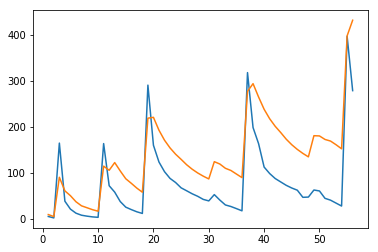

In [31]:
rows = []
for data in pyatsol.data.values():
    if not data['in'] or data['Z'] != data['N']:
        continue
    rows.append((
            data['N'], data['alpha0(BG)'],
            data['N'], data['hirsh'],
        ))
rows = np.array(rows).T
plt.plot(*rows[0:2], '-', *rows[2:4], '-')

(0, 1.6)

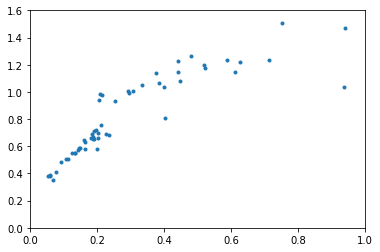

In [32]:
rows = []
for data in pyatsol.data.values():
    if not data['in'] or data['Z'] != data['N']:
        continue
    rows.append((
            data['O1'], data['O1']/(data['ionization energy']/27.2107),
        ))
rows = np.array(rows).T
plt.plot(*rows[0:2], '.')
plt.xlim((0, 1))
plt.ylim((0, 1.6))

In [33]:
# print(tabulate(table, headers='a0 a0(my) a0(ref) a02 a02(my) a02(ref) C6 C6(my) C6(ref) _'.split(), floatfmt='.2g'))

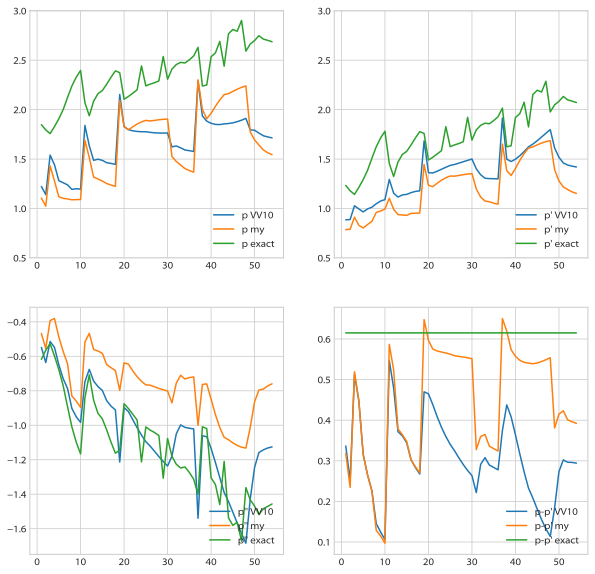

In [34]:
lines = []
for symbol, data in pyatsol.data.items():
    if data['N'] != data['Z'] or 'pp' not in data:
        continue
    pp, p = get_scaling(densities, confinements, symbol, VV10)
    pp_my, p_my = get_scaling(densities, confinements, symbol, my)
    lines.append((
            data['N'], p, data['N'], p_my, data['N'], data['p'],
            data['N'], pp, data['N'], pp_my, data['N'], data['pp'],
            data['N'], p-2*pp, data['N'], p_my-2*pp_my, data['N'], data['p']-2*data['pp'],
            data['N'], p-pp, data['N'], p_my-pp_my, data['N'], data['p']-data['pp'],
        ))
lines = np.array(lines).T
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(*lines[0:6])
plt.legend(['p VV10', 'p my', "p exact"], loc='lower right')
plt.ylim(.5, 3)
plt.subplot(2, 2, 2)
plt.plot(*lines[6:12])
plt.legend(["p' VV10", "p' my", "p' exact"], loc='lower right')
plt.ylim(.5, 3)
plt.subplot(2, 2, 3)
plt.plot(*lines[12:18])
plt.legend(["p'' VV10", "p'' my", "p'' exact"], loc='lower right')
plt.subplot(2, 2, 4)
plt.plot(*lines[18:24])
plt.legend(["p-p' VV10", "p-p' my", "p-p' exact"], loc='lower right')

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'MyriadPro-SemiExt.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


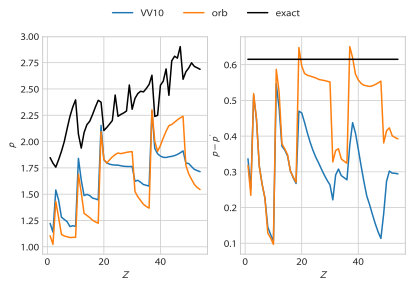

In [35]:
lines = []
for symbol, data in pyatsol.data.items():
    if data['N'] != data['Z'] or 'pp' not in data:
        continue
    pp, p = get_scaling(densities, confinements, symbol, VV10)
    pp_my, p_my = get_scaling(densities, confinements, symbol, my)
    lines.append((data['N'], p, p_my, data['p'], pp, pp_my, data['pp']))
lines = np.array(lines)

fig, axes = plt.subplots(1, 2, figsize=(6.5, 4))
handles = {}
for i, lbl in zip([1, 2, 3], ['VV10', 'orb', 'exact']):
    color = 'black' if lbl == 'exact' else None
    line, = axes[0].plot(lines[:, 0], lines[:, i], color=color)
    axes[1].plot(lines[:, 0], lines[:, i]-lines[:, i+3], color=color)
    handles[lbl] = line
for ax in axes:
    ax.set_xlabel(r'$Z$')
axes[0].set_ylabel(r'$p$')
axes[1].set_ylabel(r"$p-p'$")
fig.legend(handles.values(), handles.keys(), 'upper center', ncol=3)
savefig(fig, '/Users/hermann/Research/Projects/dissertation/pub/media/pol-scaling')